# Evaluating Thermodynamic Functions

QWavE has also implimented to evaluate the partition function from the results of the schrodinger equation, and compute free energy and entropies (other thermodynamic parameters coming soon!) Compared to the schrodinger_X() modules, computing the is fairly straight forward

# q_PESq()

The q_PESq() module evaluates the canonical partition function:

$$q_{\text{PESq}} = \sum_{i=1} \exp(-\frac{E_{i}}{k_{b} T})$$

where $E_{i}$, $k_{b}$, and $T$, are the eigenvales from the schrodinger equation modules, the Boltzmann constant, and temperature respectively. 

In [9]:
# We will test the partition function modules on the C-Pt(100) example

from qwave import qwave
import csv 
from scipy import constants
import numpy as np


bohr_to_m = constants.physical_constants['Bohr radius'][0] # convert from bohr to meter
ang_to_m = constants.physical_constants['Angstrom star'][0] # convert from angstrom to meter

au_to_kg = constants.physical_constants['atomic unit of mass'][0]  # convert from au to kg
am_to_kg = constants.physical_constants['atomic mass constant'][0] # convert from am to kg

h_to_eV = constants.physical_constants['Hartree energy in eV'][0] # convert from Eh to eV

x=[] # store data in csv
y=[]

with open('./arbitrary.csv') as csvfile:                # read csvfile
    csvreader = csv.reader( csvfile,delimiter =',')
    for row in csvreader:
        x.append(float(row[0]))
        y.append(float(row[1]))

xdata = np.multiply(x,(ang_to_m/bohr_to_m))
ydata = np.multiply(y,1/h_to_eV)

results = np.vstack((xdata,ydata)).T

np.savetxt('./scaled-arbitrary.csv',results,delimiter=',')

bl = xdata[-1]-xdata[0]      # box length (centered at zerop)
m = 12 * (am_to_kg/au_to_kg) # atomic unit of mass of C atom
eigen,wave = qwave.schrodinger_box(bl,m,
                                   pot_func='./scaled-arbitrary.csv',
                                   len_eigval = 10, 
                                   unit='eV')

# Now that we have the eigen values, we simply need to call the q_PESq() module, and 
# specify the eigen values, the temperature range, and the unit the eigenvalues are in.
# Note: you should look at the eigenvalues before evaluating anything and modify the 
# len_eigval parameter as needed. For this example we will just use the first 10 eigenvalues

temp = np.linspace(10,1200) # module will not work at very very low temperatures
Q_pesq = np.array(qwave.q_PESq(eigen,temp,'eV'))



## q_HO

We have also implimented the ability to compute the partition function given the frequency for the harmonic oscillator. It work very similarly as the q_PESq() module, except it evaluates:

$$q_{\text{HO}} =\frac{\exp(\frac{h\nu}{2 k_{b} T})}{1-\exp(\frac{h\nu}{ k_{b} T})}$$

where $h$, and $\nu$ are Plancks constant and frequency (in cm-1) respectively. 

In [5]:
freq_inplane = 543 # in-plane frequency vibration (degenerate)
freq_normal = 249 # out-of-plane frequency vibration

Q_HO_in = np.array(qwave.q_HO(freq_inplane,temp,'eV'))
Q_HO_out = np.array(qwave.q_HO(freq_normal,temp,'eV'))

With these partion functions, we can evaluate some thermodynamic properties

## free_A_S()

free_A_S() module computes the helmholtz free energy (which is the free energy which corresponds with this ensemble) and the entropy. These are computed as:

$$A = -k_{b}T\ln(\prod_{i=\text{DOF}}q_{i})$$
<br>
$$S = -\frac{\partial A}{\partial T} $$

where $i$ covers the availible degrees of freedom. Since we are dealing with a monatomic atom, all we have are the translations of the atom on the surface (translations in the x,y,z). Note 1: you can approximate these translations as frustrated vibrations on the surface. Note 2: for simplicity, we will assume that the motion normal to the surface can always be treated within the harmonic approximaiton, so $q_{z}$ will come from the freq_normal, but you are more than welcome to compute the out of plane potential and evaluate the eigenvalues for that potentials. Also we will assume that the in-plane motions are degenerate.

free_A_S() takes three parameters: q, temp, and unit. It returns both the free energy and entropy.

In [10]:
Q_HO_Tot = (Q_HO_in*Q_HO_in*Q_HO_out)
A_HO,S_HO = qwave.free_A_S(Q_HO_Tot,temp,'eV')

Q_PESq_Tot = (Q_pesq*Q_pesq*Q_HO_out)
A_PESq,S_PESq = qwave.free_A_S(Q_HO_Tot,temp,'eV')

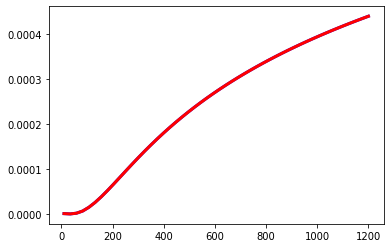

In [14]:
import matplotlib.pyplot as plt

plt.plot(temp,S_PESq,linewidth=3,color='blue')
plt.plot(temp,S_HO,linewidth=3,color='red')

In [18]:
Q_pesq[0]

1.5404675742153275e-17

In [19]:
Q_HO_in[0]

1.0845240845145971e-17